In [1]:
import pandas as pd
from COMETH import Skeleton,DynamicSkeleton
import nimblephysics as nimble
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import glob
import json
from scipy.spatial.transform import Rotation as R

gui = nimble.NimbleGUI()
gui.serve(8080)
gui.nativeAPI().clear()

Web GUI serving on http://localhost:8080
GUIWebsocketServer will start serving a WebSocket server on ws://localhost:8070


In [2]:
def create_body_model(action_name: str, action_dict: dict, vicon_path: str = './totalcapture/vicon', body_node_list: list = ['humerus_r','humerus_l',"thorax"]):
    """ 
    This function initializes the DynamicSkeleton body model with the vicon data of the given subject
    Parameters:
        - action_name: The name of the specific action to consider ('subj/action')
        - action_dict: The dict of the specific action to consider
    Returns:
        The DynamicSkeleton
    """

    subj = action_name.split('/')[-2]
    action = action_name.split('/')[-1]
    path = os.path.join(vicon_path,action_name,'vicon_'+subj+'_'+action+'.csv')

    # Build skeleton
    s12 = Skeleton('BODY12.xml')
    # BSM
    s = DynamicSkeleton(config='BODY15_constrained_3D.xml',osim_file=os.path.abspath('COMETH/bsm_upper.osim'))
    s.hip_correction = False

    # Read data from CSV
    markers = pd.read_csv(path)
    # Build the markers dataframe with only the subset we are interested in
    Rz = np.array([
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ])

    Rx = np.array([
        [1,0,0 ],
        [0,0,-1 ],
        [0,1,0]
    ])

    markers.columns
    markers_dict = {
        'RKnee': 'right_knee',
        'LWrist': 'left_wrist',
        'RHip': 'right_hip',
        'RShoulder': 'right_shoulder',
        'LElbow': 'left_elbow',
        'LHip': 'left_hip',
        'RElbow': 'right_elbow',
        'RWrist': 'right_wrist',
        'LKnee': 'left_knee',
        'LShoulder': 'left_shoulder',
        'RAnkle': 'right_ankle',
        'LAnkle': 'left_ankle'
    }

    sensors_dict = {
        'ulna_r': 'right_elbow',
        'ulna_l': 'left_elbow',
        'thorax': 'sternum',
        'humerus_r': 'right_elbow',
        'humerus_l': 'left_elbow',
        'hand_r': 'right_wrist',
        'hand_l': 'left_wrist'
        #TODO: complete with other accelerometer
    }

    offset_dict = {
        'ulna_r': [0.0,0,0],
        'ulna_l': [0.0,0,0],
        'humerus_r': [0.0,0,0],#[-0.04,-0.15,0],
        'humerus_l': [0.0,0,0],#[-0.04,-0.15,0],
        'thorax': [0.0,0,0],#[0.1, -0.1, 0.05]
        'hand_r': [0,0,0],
        'hand_l': [0,0,0]
    }

    rotation_dict = {
        'ulna_r': np.eye(3),
        'ulna_l': np.eye(3),
        'humerus_r': np.eye(3),
        'humerus_l': np.eye(3),
        'thorax': np.eye(3),
        'hand_r': np.eye(3),
        'hand_l': np.eye(3)
        #'humerus_r': np.array([[0,0,-1],[1,0,0],[0,-1,0]]),
        #'humerus_l': np.array([[0,0,-1],[1,0,0],[0,-1,0]]),
        #'thorax': np.array([[0,0,1],[1,0,0],[0,1,0]])
    }

    target = []
    for i in range(markers.shape[0]):
        row = []
        for kp in markers_dict.keys():
            p = np.array([markers[markers_dict[kp]+"_x"][i],markers[markers_dict[kp]+"_y"][i],markers[markers_dict[kp]+"_z"][i]])
            # rotate the 3d point -90 on the x axis (from y up to z up)
            p_n = Rz.dot(Rx.dot(p))
            # print(p,p_n)
            row += p_n.tolist()
        target.append(row)
    target = np.array(target)

    # Move the body model using gt to the first position
    s.reset()
    s12.load_from_numpy(target[0,:].reshape(-1,3),s.kps)
    s.load_from_BODY12(s12)
    s.exact_scale()
    s._nimble.setGravity(np.array([0.0, 0.0, -9.81]))

    
    from typing import List, Tuple
    from scipy.spatial.transform import Rotation

    sensors: List[Tuple[nimble.dynamics.BodyNode, nimble.math.Isometry3]] = []
    for node in body_node_list:
        body_node: nimble.dynamics.BodyNode = s._nimble.getBodyNode(node)
        quatern_bone = action_dict[sensors_dict[node]]['calib_bone']
        quatern_ref = action_dict[sensors_dict[node]]['calib_ref']
        #translation: np.ndarray = np.array([0.0, 0.0, 0.0]) #TODO: Where can i find the translation?
        translation: np.ndarray = np.array(offset_dict[node])
        #rotation: np.ndarray = (Rotation.from_quat(quatern_ref)).as_matrix()@np.linalg.inv((Rotation.from_quat(quatern_bone)).as_matrix())
        #rotation: np.ndarray = (Rotation.from_quat(quatern_bone)).as_matrix()
        #rotation: np.ndarray = np.eye(3)
        rotation: np.ndarray = np.array(rotation_dict[node])

        #rotation: np.ndarray = np.linalg.inv((Rotation.from_quat(quatern_bone)).as_matrix()) # in teoria nel readme le calibration sono vector first
        watch_offset: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

        sensors.append((body_node, watch_offset))
    
    s.IMUs = sensors

    return s

def plot_imu(imu,axis_length=0.1,imu_key='imu'):
    j_w = imu[0].getWorldTransform().matrix()   # From joint to world
    imu_j = imu[1].matrix()                     # From IMU to joint
    imu_w = j_w @ imu_j # From IMU to world
    
    # Origin
    p0 = imu_w @ np.eye(4)
    gui.nativeAPI().createSphere(key=imu_key+'o', radii=np.array([0.01,0.01,0.01]),pos=p0[0:3,3],color=np.array([255,255,0,1]))
    
    # X coordinate
    px = np.eye(4)
    px[0:3,3] = [axis_length,0,0]
    px = imu_w @ px
    gui.nativeAPI().createLine(key=imu_key+'x',points=[p0[0:3,3],px[0:3,3]],color=np.array([255,0,0,1]))
    
    # Y coordinate
    py = np.eye(4)
    py[0:3,3] = [0,axis_length,0]
    py = imu_w @ py
    gui.nativeAPI().createLine(key=imu_key+'y',points=[p0[0:3,3],py[0:3,3]],color=np.array([0,255,0,1]))
    
    # Z coordinate
    pz = np.eye(4)
    pz[0:3,3] = [0,0,axis_length]
    pz = imu_w @ pz
    gui.nativeAPI().createLine(key=imu_key+'z',points=[p0[0:3,3],pz[0:3,3]],color=np.array([0,0,255,1]))

def compute_gt(action_name: str, vicon_path: str):
    subj = action_name.split('/')[-2]
    action = action_name.split('/')[-1]
    path = os.path.join(vicon_path,action_name,'vicon_'+subj+'_'+action+'.csv')

    # Build skeleton
    s12 = Skeleton('BODY12.xml')
    # BSM
    s = DynamicSkeleton(config='BODY15_constrained_3D.xml',osim_file=os.path.abspath('COMETH/bsm_upper.osim'))
    s.hip_correction = False

    # Read data from CSV
    markers = pd.read_csv(path)

    # Build the markers dataframe with only the subset we are interested in
    Rz = np.array([
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ])

    Rx = np.array([
        [1,0,0 ],
        [0,0,-1 ],
        [0,1,0]
    ])

    markers.columns
    markers_dict = {
    'RKnee': 'right_knee',
    'LWrist': 'left_wrist',
    'RHip': 'right_hip',
    'RShoulder': 'right_shoulder',
    'LElbow': 'left_elbow',
    'LHip': 'left_hip',
    'RElbow': 'right_elbow',
    'RWrist': 'right_wrist',
    'LKnee': 'left_knee',
    'LShoulder': 'left_shoulder',
    'RAnkle': 'right_ankle',
    'LAnkle': 'left_ankle'
    }
    target = []
    for i in range(markers.shape[0]):
        row = []
        for kp in markers_dict.keys():
            p = np.array([markers[markers_dict[kp]+"_x"][i],markers[markers_dict[kp]+"_y"][i],markers[markers_dict[kp]+"_z"][i]])
            # rotate the 3d point -90 on the x axis (from y up to z up)
            p_n = Rz.dot(Rx.dot(p))
            # print(p,p_n)
            row += p_n.tolist()
        target.append(row)
    target = np.array(target)

    # Move the body model using gt to the first position
    kps = list(markers_dict.keys())
    s.reset()
    s12.load_from_numpy(target[0,:].reshape(-1,3),s.kps)
    s.load_from_BODY12(s12)
    s.exact_scale()

    q0 = s._nimble.getPositions().copy()
    positions = []

    for i in range(0, target.shape[0]):
        #Update gt position
        s12.load_from_numpy(target[i,:].reshape(-1,3),s.kps)
        s.load_from_BODY12(s12)
        s.exact_scale(max_iterations=100, to_scale=False)
        pos_gt = s._nimble.getPositions().copy()
        pos_gt[0:6] = q0[0:6]
        #s._nimble.setPositions(pos_gt)
        positions.append(pos_gt.reshape(-1,1))
    
    return np.array(positions)

class ImuData:
    def __init__(self, path: str):
        """ 
        Parameters
         path: str root directory of the imu sequence
        """
        self.file_path = path
        self.action = path.split('_')[-1].split('.')[0]
        self.subj = path.split('_')[-2]
        self.root_path, self.file_name = os.path.split(path)
        self.cal_file = self.subj + '_' + self.action + '_calibration.json'
        self.acc_read = None
        
    def read_imu_csv(self):
        """ 
        This function return a dict of numpy matrices (n_t x n_comp) representing the imu data of the given .csv.
        """
        # Loading data from files
        data = pd.read_csv(self.file_path, index_col=0)
        if data is None:
            return

        with open(os.path.join(self.root_path, self.cal_file), 'r') as file:
            calibration = json.load(file)

        indexes_name = data.columns.values

        # Obtaining acc names
        acc_readings = {}
        for idx in indexes_name[list(range(2,len(indexes_name),16))]:
            if 'left' in idx or 'right' in idx:
                name = idx.split('_')[0] +'_'+ idx.split('_')[1]
            else:
                name = idx.split('_')[0]
            acc_readings[name] = {}

            quaternion = data.loc[:,[name+'_quat_w', name+'_quat_x', name+'_quat_y', name+'_quat_z']]
            acc_readings[name]['quater']= quaternion.to_numpy()

            accel = data.loc[:,[name+'_acc_x', name+'_acc_y', name+'_acc_z']]
            acc_readings[name]['accel']= accel.to_numpy()

            gyro = data.loc[:,[name+'_gyro_x', name+'_gyro_y', name+'_gyro_z']]
            acc_readings[name]['gyro']= np.deg2rad(gyro.to_numpy())

            comp = data.loc[:,[name+'_comp_x', name+'_comp_y', name+'_comp_z']]
            acc_readings[name]['comp']= comp.to_numpy()

            grav = data.loc[:,[name+'_g_x', name+'_g_y', name+'_g_z']]
            acc_readings[name]['grav']= grav.to_numpy()

            acc_readings[name]['calib_bone'] = np.array(calibration['bone'][name])
            acc_readings[name]['calib_ref'] = np.array(calibration['ref'][name])
        
        acc_readings['n_frames'] = len(data.index)

        self.acc_read = acc_readings

    def get_imu_array(self, joint_list):
        acc =[]
        gyro = []
        for joint in joint_list:
            acc.append(self.acc_read[joint]['accel'])
            gyro.append(self.acc_read[joint]['gyro'])

        return np.array(acc), np.array(gyro)
    
    def get_world_orient(self, joint_list):
        ori = []
        for joint in joint_list:
            
            quat_ref = np.tile(self.acc_read[joint]['calib_ref'], (len(self.acc_read[joint]['quater']),1))
            #ori.append(rotation.batch_quat_mul(rotation.quat_vectorfirst_to_scalarfirst(quat_ref),self.acc_read[joint]['quater']))
            ori.append(self.acc_read[joint]['quater'])
        
        return np.array(ori)

In [3]:
#To transfer inside DynamicSkeleton class
def getImuWorldOrient(s):
    #return the imu "from imu to world" rotation as transfrom matrix.
    rot = []
    for imu in s.IMUs:
        T_b_w = imu[0].getWorldTransform().matrix()
        T_i_b = imu[1].matrix()

        T_i_w = T_b_w @ T_i_b

        rot.append(T_i_w)
    
    return np.array(rot)

def getImuWorldPosition(s):
    pos = []
    for imu in s.IMUs:
        T_b_w = imu[0].getWorldTransform().matrix()
        T_i_b = imu[1].matrix()

        T_i_w = T_b_w @ T_i_b
        pos.append(T_i_w[:3,3].reshape(3))
        
    return np.array(pos)

def correctImuOrient(s, R_corr):
    """ R_corr è (Nx3x3) ed è da old imu a new imu """
    
    for i, imu in enumerate(s.IMUs):
        T_i_b = imu[1].matrix()
        T = np.eye(4)
        T[:3,:3]= R_corr[i]

        T_corr = T@T_i_b

        s.IMUs[i] = (imu[0],nimble.math.Isometry3(T_corr[:3,:3], T_corr[:3,3]))# R_t_b[i] offset_t_b[i]


def setImuWorldTransform(s, T_i_w):
    """WARNING: FOR NOW ONLY THE ROTATION IS APPLIED!!!"""
    for i, imu in enumerate(s.IMUs):
        T_b_w = imu[0].getWorldTransform().matrix()
        T_old = imu[1].matrix()
        T_i_b = np.linalg.inv(T_b_w)@T_i_w[i]
        s.IMUs[i] = (imu[0],nimble.math.Isometry3(T_i_b[:3,:3], T_old[:3,3]))

In [4]:
pos_gt = compute_gt('s1/acting1', './totalcapture/vicon/')

Setting len to 0.1
Setting neutral pos to   0
0.7
  0
Setting len to 0.3
Setting neutral pos to    0
-0.6
   0
Setting len to 0.1
Setting neutral pos to   0
0.2
  0


In [5]:

############################################
# Helper functions
############################################

def skew(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

def so3_log(R):
    tr = np.trace(R)
    cos_theta = (tr - 1) / 2.0
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    if theta < 1e-12:
        return np.zeros(3)
    return (theta / (2 * np.sin(theta))) * np.array([
        R[2, 1] - R[1, 2],
        R[0, 2] - R[2, 0],
        R[1, 0] - R[0, 1]
    ])

############################################
# Modified DH transform
############################################

def mdh_transform(theta, a, alpha, d):
    cz, sz = np.cos(theta), np.sin(theta)
    ca, sa = np.cos(alpha), np.sin(alpha)
    T = np.array([
        [cz, -sz*ca,  sz*sa, a*cz + d*sz*sa],
        [sz,  cz*ca, -cz*sa, a*sz - d*cz*sa],
        [0,      sa,     ca,     d*ca],
        [0,      0,      0,     1]
    ])
    return T


############################################
# ArmModel: rappresenta un braccio
############################################


class ArmModel:
    def __init__(self, dh_params, R_seg_to_imu, p_seg_to_imu,
                 R_seg_to_marker, p_seg_to_marker,
                 R_imu_to_cam, p_imu_to_cam,
                 gravity=np.array([0, 0, -9.80665])):
        """
        dh_params: lista di dict per tronco + giunti braccio (es. 6 DOF: tronco + 5 giunti)
        R_seg_to_imu: lista di rotazioni IMU per [tronco, upper arm, forearm]
        p_seg_to_imu: lista di offset IMU per [tronco, upper arm, forearm]
        """
        self.dh = dh_params
        self.R_seg_to_imu = R_seg_to_imu #rotazione da imu a segment
        self.p_seg_to_imu = p_seg_to_imu #nel sist di rif segment
        self.R_seg_to_marker = R_seg_to_marker #rotazione da marker a segment
        self.p_seg_to_marker = p_seg_to_marker #posizione del marker in sist rif segment
        # Camera sul tronco → coincide con il primo segmento
        self.R_imu_to_cam = R_imu_to_cam
        self.p_imu_to_cam = p_imu_to_cam
        self.g = gravity
        self.n = len(dh_params)  # DOF totale (tronco + braccio)


    def forward_kinematics(self, q):
        """Calcola posizioni, rotazioni e assi z per tutti i giunti."""
        T = np.eye(4)
        positions, rotations, z_axes = [], [], []
        for i in range(len(q)):
            link = self.dh[i]
            Ti = mdh_transform(q[i], link['a'], link['alpha'], link['d'])
            T = T @ Ti
            positions.append(T[:3, 3]) #rotazione giunto-->world
            rotations.append(T[:3, :3]) #posizione di giunto nel world
            z_axes.append(T[:3, 2])
        return positions, rotations, z_axes

    
    def imu_measurement(self, q, qd, qdd, seg_index):
        """
        Calcola misura IMU per il segmento indicato:
        seg_index = 0 → tronco
        seg_index = 1 → upper arm
        seg_index = 2 → forearm
        """
        positions, rotations, z_axes = self.forward_kinematics(q)
        omega = np.zeros(3)
        for j in range(seg_index+1):
            omega += z_axes[j] * qd[j]
        alpha = np.zeros(3)
        omega_prev = np.zeros(3)
        for j in range(seg_index+1):
            alpha += z_axes[j]*qdd[j] + np.cross(omega_prev, z_axes[j])*qd[j]
            omega_prev += z_axes[j]*qd[j]
        Rw = rotations[seg_index] #da segmento a world
        r_i_world = Rw @ self.p_seg_to_imu[seg_index] 
        a_i = np.cross(alpha, r_i_world) + np.cross(omega, np.cross(omega, r_i_world))
        R_G_IMU = Rw @ self.R_seg_to_imu[seg_index] #il risultato deve essere da world a imu => R_seg_to_imu è da imu a segmento
        gyro = R_G_IMU.T @ omega
        accel = R_G_IMU.T @ (a_i - self.g)
        return np.hstack([gyro, accel])


    
    def marker_measurement(self, q):
        """
        Calcola la posa del marker nel frame camera.
        La camera è sul tronco → usa il primo segmento come riferimento.
        """
        #NB: in questo caso il tronco sarebbe sulla spalla (traslazione di circa 15 cm)
        positions, rotations, _ = self.forward_kinematics(q)
        Rw_marker = rotations[-1] #è dal seg al world
        pw_marker = positions[-1] #posizione del segment nel world
        R_W_marker = Rw_marker @ self.R_seg_to_marker # dal marker al world => R è da marker->seg
        p_W_marker = pw_marker + Rw_marker @ self.p_seg_to_marker #p é posizione del marker in sist rif segment, il risultato è posizione del maker in sist rif world
        # Camera sul tronco (segmento 0)
        R_cam = rotations[2]@self.R_seg_to_imu[2]@self.R_imu_to_cam.T # da tronco a world @ da imu a tronco @ da cam a imu => da cam a world
        p_cam = positions[2] + rotations[2]@self.p_seg_to_imu[2] + rotations[2]@self.R_seg_to_imu[0]@self.p_imu_to_cam#pos di tronco in world + posizione di imu in tronco riportato al world + pos di cam in imu riportato al world
        R_C_marker = R_cam.T @ R_W_marker # da marker alla cam
        p_C_marker = R_cam.T @ (p_W_marker - p_cam) # coordinate marker relative alla cam  in sist riferimento cam
        return R_C_marker, p_C_marker
    

def compute_modified_dh(T_list, right : bool = True):
    """
    Calcola i parametri DH modificati per una catena di giunti.
    T_list: lista di matrici 4x4 giunto->world in ordine.
    """
    
    offset = []
    for i in range(len(T_list) - 1):
        T_rel = np.linalg.inv(T_list[i]) @ T_list[i+1] # da i+1 a i
        dist = np.linalg.norm(T_rel[:3,3]) # distanza tra i+1 ed i
        offset.append(dist)

    sign = -1
    if right:
        sign = 1

    dh_params = [
        #tronco yaw
        {'a': 0.0,  'alpha': +np.pi/2, 'd': 0.0},
        #tronco pitch
        {'a': 0.0,  'alpha': -np.pi/2, 'd': 0.0},
        #tronco roll
        {'a': sign * offset[0],  'alpha': 0.0,    'd': 0.0}, #distanza torace spalla
        #spalla yaw
        {'a': 0.0,  'alpha': +np.pi/2, 'd': 0.0},
        #spalla pitch
        {'a': 0.0,  'alpha': -np.pi/2, 'd': 0.0},
        #spalla roll
        {'a': offset[1], 'alpha': 0.0, 'd': 0.0}, #distanza spalla gomito
        #gomito flex
        {'a': offset[2], 'alpha': 0.0, 'd': 0.0}, #distanza gomito polso
        #pronation
        {'a': 0.0,  'alpha': 0.0,      'd': 0.0},
    ]
    return dh_params

def compute_list(s):
    T_list = []
    for node in ['ulna_r','ulna_l','humerus_r', 'humerus_l', "thorax", "hand_r","hand_l"]:
        body_node: nimble.dynamics.BodyNode = s._nimble.getBodyNode(node)
        T_list.append(body_node.getWorldTransform().matrix())
    T_list_r = [T_list[4],T_list[2],T_list[0], T_list[5]]
    T_list_l = [T_list[4],T_list[3],T_list[1], T_list[6]]

    return T_list_r, T_list_l #da body a world


In [6]:

############################################
# EKF globale per due bracci
############################################

class DualArmEKF:
    def __init__(self, arms, Q, R_dict):
        """
        arms: lista di ArmModel [destro, sinistro]
        Stato: [q_R(5), qd_R(5), qdd_R(5), q_L(5), qd_L(5), qdd_L(5)]
        """
        self.arms = arms
        self.n_arm = arms[0].n
        self.state = np.zeros(6 * self.n_arm)  # 36 variabili
        self.P = np.eye(6 * self.n_arm) * 1e-2
        self.Q = Q
        self.R = R_dict

    def predict(self, dt):
        """Predizione stato con modello a accelerazione costante."""
        n = self.n_arm
        # Braccio destro
        qR = self.state[0:n]
        qdR = self.state[n:2*n]
        qddR = self.state[2*n:3*n]
        qR = qR + qdR*dt + 0.5*qddR*dt*dt
        qdR = qdR + qddR*dt
        # Braccio sinistro
        qL = self.state[3*n:4*n]
        qdL = self.state[4*n:5*n]
        qddL = self.state[5*n:6*n]
        qL = qL + qdL*dt + 0.5*qddL*dt*dt
        qdL = qdL + qddL*dt
        # Aggiorna stato
        self.state = np.hstack([qR, qdR, qddR, qL, qdL, qddL])
        # Aggiorna covarianza
        A = np.eye(6*n)
        for offset in [0, 3*n]:
            A[offset:offset+n, offset+n:offset+2*n] = np.eye(n)*dt
            A[offset:offset+n, offset+2*n:offset+3*n] = np.eye(n)*0.5*dt*dt
            A[offset+n:offset+2*n, offset+2*n:offset+3*n] = np.eye(n)*dt
        self.P = A @ self.P @ A.T + self.Q


    def update_imu(self, z_all, R_block=None, use_joseph=True):
        """
        Aggiorna l'EKF con TUTTE le IMU in un'unica fase (batch).
        
        Parametri
        ---------
        z_all : iterable di tuple (arm_id, seg_index, z)
            - arm_id: 0 = braccio destro, 1 = braccio sinistro
            - seg_index: indice del segmento nella catena DH dell'ArmModel
                        (es. 0=tronco, 3=upper-arm, 4=forearm, ... in base ai tuoi DH)
            - z: misura IMU come array (6,) = [wx, wy, wz, fx, fy, fz]
        R_block : np.ndarray o None
            - Se None: usa block-diagonal con self.R['imu'] su ciascun blocco (6x6)
            - Se fornita: matrice di covarianza completa (dimensione 6*M x 6*M)
        use_joseph : bool
            - Se True, usa la forma di Joseph per aggiornare P (più stabile numericamente).
        
        Note
        ----
        - Tutte le misure sono linearizzate attorno allo stesso stato a priori (batch EKF).
        - Se hai sensori asincroni, chiama questa funzione solo per quelli allineati allo stesso timestamp;
        altrimenti usa update separati e interponi predict(dt).
        """
        n = self.n_arm
        x_dim = len(self.state)

        # Stacking di z, h, H (predizione misura, residuo e jacobiano globale)
        z_stack = []
        h_stack = []
        H_rows = []

        # Per costruire R block-diagonale se non fornita
        blocks_count = 0

        for (arm_id, seg_index, z) in z_all:
            # Offset di stato per il braccio scelto
            idx_start = arm_id * 3 * n
            arm = self.arms[arm_id]

            # Stato locale (q, qd, qdd) del braccio
            x_local = self.state[idx_start:idx_start + 3*n]
            q   = x_local[0:n]
            qd  = x_local[n:2*n]
            qdd = x_local[2*n:3*n]

            # Funzione di misura IMU (gyro+accel) nel segmento richiesto
            h_i = arm.imu_measurement(q, qd, qdd, seg_index)     # (6,)
            # Jacobiano numerico locale (6 x 15) rispetto al blocco del braccio
            active = np.array(list(range(2*n)))
            H_local = self.numeric_jacobian(
                func=lambda xl: arm.imu_measurement(xl[:n], xl[n:2*n], xl[2*n:], seg_index),
                active_idx = active,
                x=x_local
            )  # shape: (6, 3*n)

            # Inserimento nelle strutture globali
            z_stack.append(z.reshape(6))
            h_stack.append(h_i.reshape(6))

            # Costruisci una riga-blocco del Jacobiano globale (6 x x_dim)
            H_i = np.zeros((6, x_dim))
            H_i[:, idx_start:idx_start + 3*n] = H_local
            H_rows.append(H_i)

            blocks_count += 1

        if blocks_count == 0:
            return  # niente da aggiornare

        # Stack finale
        z_stack = np.vstack(z_stack)             # (6M x 1)
        h_stack = np.vstack(h_stack)             # (6M x 1)
        H = np.vstack(H_rows)                    # (6M x x_dim)
        y = (z_stack - h_stack).reshape(-1)      # residuo

        # Covarianza di misura
        if R_block is None:
            Rm_single = self.R['imu']            # (6 x 6)
            Rm = self._block_diag(Rm_single, blocks_count)  # (6M x 6M)
        else:
            Rm = R_block

        # Innovation covariance e gain
        S = H @ self.P @ H.T + Rm
        ################diagnostica
        # row_norms = np.linalg.norm(H, axis=1)
        # bad = np.where(row_norms > 1e6)[0]
        # print(">>> BAD ROWS:", bad)
        # print("H[bad]:", H[bad])
        # col_norms = np.linalg.norm(H, axis=0)
        # print("BAD COLS:", np.where(col_norms > 1e6)[0])
        # print(f"cond di S: {np.linalg.cond(S)}")
        # print(f"rank di H: {np.linalg.matrix_rank(H)}")
        # print(f"eigen di P: {np.linalg.eigvals(self.P)}")
        # # shapes e nan/inf
        # print("S.shape", S.shape, "H.shape", H.shape, "anynan", np.isnan(H).any(), np.isinf(H).any())

        # # singular values di H (per capire quali direzioni si perdono)
        # U, s, Vt = np.linalg.svd(H, full_matrices=False)
        # print("svd(H) sing vals:", s)

        # # rank numerico (svd threshold)
        # tol = max(H.shape) * np.finfo(float).eps * s[0]
        # num_rank = np.sum(s > tol)
        # print("numeric rank(H):", num_rank, "tol", tol)

        # # singolari di S e cond
        # us, ss, vs = np.linalg.svd(S, full_matrices=False)
        # print("singvals(S):", ss, "cond(S):", ss[0]/ss[-1])

        # # isola le righe/colonne di H molto piccole
        # row_norms = np.linalg.norm(H, axis=1)
        # print("min/median/max row norms of H:", row_norms.min(), np.median(row_norms), row_norms.max())
        ######### Fine diagnostica
        K = self.P @ H.T @ np.linalg.inv(S)

        # Aggiorna stato
        self.state = self.state + K @ y

        # Aggiorna covarianza (forma di Joseph opzionale per stabilità numerica)
        I = np.eye(x_dim)
        if use_joseph:
            self.P = (I - K @ H) @ self.P @ (I - K @ H).T + K @ Rm @ K.T
        else:
            self.P = (I - K @ H) @ self.P


    def update_marker(self, arm_id, z_pos, z_rot, use_joseph:bool = True):
        """Aggiornamento EKF con misura marker (posizione + orientazione)."""
        n = self.n_arm
        idx_start = arm_id * 3 * n
        arm = self.arms[arm_id]
        q = self.state[idx_start:idx_start+n]
        R_pred, p_pred = arm.marker_measurement(q) # R è da seg a camera
        # Posizione
        y_p = z_pos - p_pred
        Hp_local = self.numeric_jacobian(lambda x: arm.marker_measurement(x[:n])[1],
                                         x=self.state[idx_start:idx_start+3*n],
                                         active_idx=np.array(list(range(n))))
        Hp = np.zeros((3, len(self.state)))
        Hp[:, idx_start:idx_start+3*n] = Hp_local
        Sp = Hp @ self.P @ Hp.T + self.R['marker_pos']
        Kp = self.P @ Hp.T @ np.linalg.inv(Sp)
        self.state += Kp @ y_p
        self.P = (np.eye(len(self.state)) - Kp @ Hp) @ self.P
        # Orientazione
        r = so3_log(z_rot @ R_pred.T)
        #Hr = np.zeros((3, len(self.state)))
        #Hr[:, idx_start:idx_start+n] = np.eye(3, n)  # semplificazione
        q_local = self.state[idx_start:idx_start+n].copy()

        # funzione che ritorna vettore 3 della "rot residual" per un q
        def rot_residual(q_var):
            R_pred_var, _ = arm.marker_measurement(q_var)
            # r = so3_log(R_meas * R_pred^T)
            return so3_log(z_rot @ R_pred_var.T)

        Hr_local = self.numeric_jacobian(func=rot_residual, x=q_local, active_idx=np.array(list(range(n))))  # (3 x n)

        Hr = np.zeros((3, len(self.state)))
        Hr[:, idx_start:idx_start+n] = Hr_local
        Sr = Hr @ self.P @ Hr.T + self.R['marker_rot']
        Kr = self.P @ Hr.T @ np.linalg.inv(Sr)
        self.state += Kr @ r
        self.P = (np.eye(len(self.state)) - Kr @ Hr) @ self.P
        """ # Aggiorna covarianza (forma di Joseph opzionale per stabilità numerica)
        I = np.eye(len(self.state))
        if use_joseph:
            self.P = (I - Kr @ Hr) @ self.P @ (I - Kr @ Hr).T + Kr @ Rm @ Kr.T
        else:
            self.P = (I - Kr @ Hr) @ self.P """

    # def numeric_jacobian(self, func, x0, eps=1e-6):
    #     """Calcolo Jacobiano numerico con differenze finite."""
    #     f0 = func(x0)
    #     m = len(f0)
    #     n = len(x0)
    #     J = np.zeros((m, n))
    #     for i in range(n):
    #         x1 = x0.copy()
    #         x1[i] += eps
    #         f1 = func(x1)
    #         J[:, i] = (f1 - f0)/eps
    #     return J
    
    def numeric_jacobian(self, func, x, active_idx=None, eps=1e-6):
        """
        Calcola la Jacobiana numerica della funzione 'func' rispetto al vettore x.
        - active_idx: array/list degli indici da derivare.
                    Se None => tutte le colonne sono attive.
        - Le colonne non attive vengono lasciate a zero.
        """
        x = np.asarray(x)
        y0 = func(x)
        m = y0.size
        n = x.size

        J = np.zeros((m, n), dtype=float)

        if active_idx is None:
            active_idx = np.arange(n)
        else:
            active_idx = np.asarray(active_idx)

        for j in active_idx:
            x_pert = x.copy()
            x_pert[j] += eps

            y_pert = func(x_pert)
            # differenza numerica robusta
            dy = y_pert - y0
            # fallback anti-nan/anti-inf
            if not np.all(np.isfinite(dy)):
                dy = np.nan_to_num(dy, nan=0.0, posinf=0.0, neginf=0.0)

            J[:, j] = dy / eps

        return J
    
    def _block_diag(self, R_single, count):
        """
        Crea una matrice block-diagonale con 'count' copie di R_single (k x k).
        Risultato: (count*k) x (count*k)
        """
        k = R_single.shape[0]
        R = np.zeros((count*k, count*k))
        for i in range(count):
            R[i*k:(i+1)*k, i*k:(i+1)*k] = R_single
        return R

In [7]:

from scipy.optimize import least_squares

# Cinematica diretta: calcola posizioni giunti date le theta
def forward_kinematics(dh_params, thetas):
    T = np.eye(4)
    positions = [T[:3, 3]]  # origine globale
    for i, params in enumerate(dh_params):
        a, alpha, d = params['a'], params['alpha'], params['d']
        T = T @ mdh_transform(thetas[i], a, alpha, d)
        positions.append(T[:3, 3])
    return positions

# Funzione obiettivo per IK
def ik_objective(thetas, dh_params, target_positions):
    predicted_positions = forward_kinematics(dh_params, thetas)
    # Flatten error
    error = []
    for p_pred, p_target in zip(predicted_positions[1:], target_positions):  # skip base
        error.extend(p_pred - p_target)
    return error

# Funzione principale IK
def inverse_kinematics(dh_params, target_positions, initial_guess=None):
    if initial_guess is None:
        initial_guess = np.zeros(len(dh_params))  # start from zero angles
    result = least_squares(ik_objective, initial_guess, args=(dh_params, target_positions))
    return result.x  # angoli stimati


def compute_world_transf(dh_params, s, right:bool = True):

    # Sistema sta porcheria
    if right:
        body_node_list = ["thorax", "humerus_r","humerus_r","humerus_r", "ulna_r", "hand_r","hand_r"]
    else:
        body_node_list = ["thorax", "humerus_l","humerus_l","humerus_l", "ulna_l", "hand_l","hand_l"]

    target_positions = []
    for i, node in enumerate(body_node_list):
        body_node: nimble.dynamics.BodyNode = s._nimble.getBodyNode(node)
        T_nimb = body_node.getWorldTransform().matrix()
        if i==0:
            offset = T_nimb[:3,3].reshape(-1)
        else:
            target_positions.append(T_nimb[:3,3].reshape(-1)-offset)
    #target positions in sdr world con origine in thorax

    # Calcolo IK
    thetas = inverse_kinematics(dh_params, target_positions)

    # Calcolo matrici T global-->link
    T_global_links = []
    T = np.eye(4)
    for i, params in enumerate(dh_params):
        T = T @ mdh_transform(thetas[i], params['a'], params['alpha'], params['d'])
        T_global_links.append(np.linalg.inv(T))

    return T_global_links, thetas

def compute_imu_ori(dh_params, s, right:bool = True):
    T_dh, _ = compute_world_transf(dh_params, s, right) # le T sono da world a link

    T_w_link = np.array([T_dh[0], T_dh[2], T_dh[5]])

    T_i_w_list_all = getImuWorldOrient(s) # da imu a world

    if right:
        T_i_w_list = np.array([T_i_w_list_all[4], T_i_w_list_all[2], T_i_w_list_all[0]]) # thorax, right_elbow, right_wrist
    else:
        T_i_w_list = np.array([T_i_w_list_all[4], T_i_w_list_all[3], T_i_w_list_all[1]]) # thorax, left_elbow, left_wrist


    T_i_link = T_w_link @ T_i_w_list #da imu a link
    
    return [T_i_link[i, :3, :3].reshape(3,3) for i in range(T_i_link.shape[0])]


In [8]:
def camera_simulation(body_pos, camera_pos, fov_h = 1.78024, fov_v = 0.994838, R_cam = np.eye(3)):
    
    points_rel = body_pos - camera_pos # Nx3 pos relativa tra camera e giunti nel world
    points_cam = points_rel @ R_cam  # Nx3 riporto la pos relativa nel sistema camera

    x = points_cam[:, 0]
    y = points_cam[:, 1]
    z = points_cam[:, 2]

    in_front = z > 0

    theta_h = np.arctan2(y, z)
    theta_v = np.arctan2(x, z)

    in_fov_h = np.abs(theta_h) <= fov_h / 2
    in_fov_v = np.abs(theta_v) <= fov_v / 2

    visible = in_front & in_fov_h & in_fov_v

    # Nan for non-visible joints
    points_filtered = body_pos.copy().astype(float) - camera_pos
    points_filtered[~visible] = np.nan

    return points_filtered[0,:].reshape(3), points_filtered[1,:].reshape(3)

In [9]:
import matplotlib.pyplot as plt
def plot_error(
    frames,
    series_names = None,
    x_labels = None,
    title: str = "MPJPE",
    y_label: str = "Tempo (s)",
    show: bool = True,
    output_path: str = "prova.svg",
):
    
    dim = frames[0].shape[0]
    # Validazione dati
    if not isinstance(frames, list) or len(frames) == 0:
        raise ValueError("`frames` deve essere una lista non vuota di np.ndarray.")
    n_frames = len(frames)

    # Costruzione matrice (n_frames x 6)
    data = np.vstack(frames)  # shape: (n_frames, 6)

    # Asse X
    if x_labels is None:
        x = np.arange(1, n_frames + 1)  # 1..N
        x_labels = x
    else:
        if len(x_labels) != n_frames:
            raise ValueError("`x_labels` deve avere la stessa lunghezza di `frames`.")
        x = np.arange(1, n_frames + 1)

    # Nomi serie
    if series_names is None:
        series_names = [f"Serie {i+1}" for i in range(dim)]
    else:
        if len(series_names) != dim:
            raise ValueError("`series_names` deve contenere esattamente 6 nomi.")

    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))
    for col in range(dim):
        ax.plot(
            x,
            data[:, col],
            marker="o",
            linewidth=2,
            label=series_names[col],
        )

    # Titoli e assi
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Frame temporale", fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)

    # Etichette X
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=0)

    # Griglia e legenda
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(title="Serie", ncol=3, fontsize=9)

    fig.tight_layout()

    # Salvataggio su file, se richiesto
    if output_path:
        fig.savefig(output_path, dpi=160)

    if show:
        plt.show()

    return fig, ax


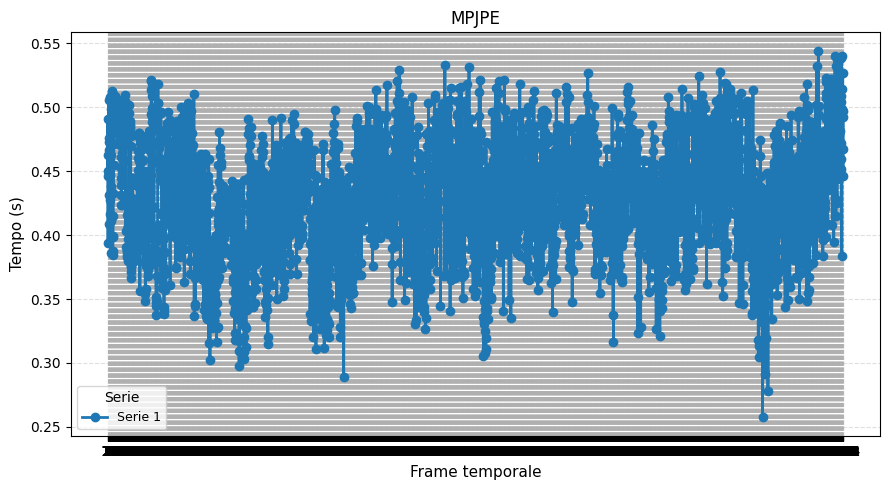

(<Figure size 900x500 with 1 Axes>,
 <AxesSubplot:title={'center':'MPJPE'}, xlabel='Frame temporale', ylabel='Tempo (s)'>)

In [15]:
from sf_utils import input_sim, rotation
from sf_utils.metrics import body_pose_metrics
from scipy.spatial.transform import Rotation as R

gui.nativeAPI().clear()

# Loading data from .csv
imu_cont = ImuData('./raw_imu_data/imu_s1_acting1.csv')
imu_cont.read_imu_csv()

imu = imu_cont.acc_read
acc, gyro = imu_cont.get_imu_array(['right_wrist','left_wrist','right_elbow', 'left_elbow', 'sternum'])

# Preparing GT model
s = create_body_model('s1/acting1', imu, body_node_list=['ulna_r','ulna_l','humerus_r', 'humerus_l', "thorax"]) # do not change imus order


s._nimble.setVelocities(np.zeros((49,1)))
s._nimble.setAccelerations(np.zeros((49,1)))
start_pos = s._nimble.getPositions()

# Inizialiting other things
dt = 1/60
mm = body_pose_metrics.MetricManager(s, [], pos_gt)

# DH parameters calculation
T_list_r, T_list_l = compute_list(s)
dh_right = compute_modified_dh(T_list_r, right=True)
dh_left = compute_modified_dh(T_list_l, right=False)

# Setting IMU orientation
theta_cam = np.deg2rad(-75)
R_cam_imu = np.array([[np.cos(theta_cam), 0, np.sin(theta_cam)],[0,1,0],[-np.sin(theta_cam),0,np.cos(theta_cam)]]) #rotazione da cam a imu thorax

T = np.array([np.eye(4), np.eye(4), np.eye(4),np.eye(4), np.eye(4)])
T[:,:3,:3] = rotation.batch_quat_to_rotmat(imu_cont.get_world_orient(['right_wrist','left_wrist','right_elbow', 'left_elbow', 'sternum'])[:,0])
setImuWorldTransform(s,T)

""" dh_right = [
    # Link 0: Tronco (base del braccio destro) – yaw del tronco
    {'a': 0.15,  'alpha': 0.0,      'd': 0.0},
    # Link 1: Spalla yaw
    {'a': 0.0,  'alpha': +np.pi/2, 'd': 0.0},
    # Link 2: Spalla pitch
    {'a': 0.0,  'alpha': -np.pi/2, 'd': 0.0},
    # Link 3: Spalla roll + LUNGHEZZA OMERO (a = 0.30 m)
    {'a': 0.30, 'alpha': 0.0,      'd': 0.0},
    # Link 4: Gomito flex/extend + LUNGHEZZA AVAMBRACCIO (a = 0.25 m)
    {'a': 0.25, 'alpha': 0.0,      'd': 0.0},
    # Link 5: Polso pron/sup (rotazione pura)
    {'a': 0.0,  'alpha': 0.0,      'd': 0.0},
]"""


R_r = compute_imu_ori(dh_right, s, right= True) #from imu to link
R_seg_to_imu_r = [np.eye(3), np.eye(3), R_r[0], np.eye(3), np.eye(3), R_r[1], R_r[2], np.eye(3)]#[R_trunk_IMU, R_upper_IMU, R_fore_IMU]
p_seg_to_imu_r = [np.array([0,0,0]), np.array([0,0,0]), np.array([-0.15,0,0]), np.array([0,0,0]), np.array([0,0,0]), np.array([-0.15,0,0]), np.array([-0.12,0,0]), np.array([0,0,0])]
R_seg_to_marker_r = np.eye(3)
p_seg_to_marker_r = np.zeros(3)
R_l = compute_imu_ori(dh_left, s, right= False)
R_seg_to_imu_l = [np.eye(3), np.eye(3), R_l[0], np.eye(3), np.eye(3), R_l[1], R_l[2], np.eye(3)]#[R_trunk_IMU, R_upper_IMU, R_fore_IMU]
p_seg_to_imu_l = [np.array([0,0,0]), np.array([0,0,0]), np.array([0.15,0,0]), np.array([0,0,0]), np.array([0,0,0]), np.array([-0.15,0,0]), np.array([-0.12,0,0]), np.array([0,0,0])] #Riconsidera la prima traslazione sapendo che impatta su dove metti la camera...
R_seg_to_marker_l = np.eye(3) #lasciare coincidente per evitare rogne dopo
p_seg_to_marker_l = np.zeros(3)
R_imu_to_cam = R_cam_imu #rotazione dalla cam a imu del tronco
p_imu_to_cam = np.zeros(3) #coordinate della cam in sdr imu del tronco, lascia nullo perchè coicide con la imu di torace

arm_right = ArmModel(dh_right, R_seg_to_imu_r, p_seg_to_imu_r,
                        R_seg_to_marker_r, p_seg_to_marker_r,
                        R_imu_to_cam, p_imu_to_cam)
arm_left = ArmModel(dh_left, R_seg_to_imu_l, p_seg_to_imu_l,
                    R_seg_to_marker_l, p_seg_to_marker_l,
                    R_imu_to_cam, p_imu_to_cam)


# creation of Q
Q_q = np.eye(8)*1e-6
Q_qd = np.eye(8)*1e-5
Q_qdd = np.eye(8)*1e-4
Q_arm = np.block([[Q_q, np.zeros((8,8)), np.zeros((8,8))], [np.zeros((8,8)), Q_qd, np.zeros((8,8))], [np.zeros((8,8)), np.zeros((8,8)), Q_qdd]] )
Q_whole = np.block([[Q_arm, np.zeros((24, 24))], [np.zeros((24, 24)),Q_arm]])

#Da settare con dati veri
ekf = DualArmEKF([arm_right, arm_left],
                    Q=Q_whole,
                    R_dict={'imu': np.eye(6)*1e-4,
                            'marker_pos': np.eye(3)*1e-6, #è gt
                            'marker_rot': np.eye(3)*1e-6})#è gt

acc, gyro = imu_cont.get_imu_array(['right_wrist','left_wrist','right_elbow', 'left_elbow', 'sternum'])

errors = []

for i in range(0, imu['n_frames']):
    
    s._nimble.setPositions(pos_gt[i])
    gui.nativeAPI().renderSkeleton(s._nimble)
    for j,sensor in enumerate(s.IMUs):
        plot_imu(s.IMUs[j],axis_length=0.05,imu_key='imu'+str(j))
    
    #ad ogni frame creo i rispettivi nparray dei dati imu
    z_all = [
        (0, 2, np.array([gyro[4,i],acc[4,i]*9.80665]).reshape(6)),   # braccio destro, tronco
        (0, 5, np.array([gyro[2,i],acc[2,i]*9.80665]).reshape(6)),   # braccio destro, upper-arm (link 3)
        (0, 7, np.array([gyro[0,i],acc[0,i]*9.80665]).reshape(6)),    # braccio destro, forearm (link 4) #era 4, ma forse più corretto 5
        (1, 2, np.array([gyro[4,i],acc[4,i]*9.80665]).reshape(6)),   # braccio sinistro, tronco
        (1, 5, np.array([gyro[3,i],acc[3,i]*9.80665]).reshape(6)),   # braccio sinistro, upper-arm
        (1, 7, np.array([gyro[1,i],acc[1,i]*9.80665]).reshape(6)),    # braccio sinistro, forearm
    ]
    

    ekf.predict(dt)
    
    ekf.update_imu(z_all)
    
    if i%10 == 0:

        R_imu_w = getImuWorldOrient(s)[4,:3,:3] #nimble imu->world orient ( camera coincide con l'imu di torace)
        R_cam_w = R_imu_w@R_imu_to_cam  # cam --> world
        
        camera_pos = getImuWorldPosition(s)[4] + R_imu_w@p_imu_to_cam #nimble camera position (camera coincide con l'imu di torace)

        R_l_w = getImuWorldOrient(s)[1,:3,:3]@R_seg_to_marker_l #(marker -> world)
        R_r_w = getImuWorldOrient(s)[0,:3,:3]@R_seg_to_marker_r

        #fai che getti le posizione delle imu e correggi con le reletive dei marker. 

        pos_target = (s._nimble.getJointWorldPositions(s.joints)).reshape(-1,3)[[1,7],:] #first is left, second is  right #posizioni dei polsi nel world
        z_pos_cam_l, z_pos_cam_r = camera_simulation(pos_target, camera_pos=camera_pos, R_cam= R_cam_w) #pos relativa tra polso e camera nel sist riferimento camera
        


        # Ad ogni frame creo i rispettivi nparray dei polsi visti da camera
      
        #z_rot deve essere da segmento a camera, z_pos è coordinate marker relative alla cam  in sist riferimento cam
        if not np.any(np.isnan(z_pos_cam_r)):
            z_rot_cam_r = (R_cam_w.T@R_r_w) # Deve essere dal marker a camera
            ekf.update_marker(arm_id=0, z_pos=z_pos_cam_r@R_imu_w, z_rot=z_rot_cam_r)
        if not np.any(np.isnan(z_pos_cam_l)):
            z_rot_cam_l = (R_cam_w.T@R_l_w)
            ekf.update_marker(arm_id=1, z_pos=z_pos_cam_l@R_imu_w, z_rot=z_rot_cam_l)

    
    q_est = (ekf.state.reshape(8,6)[:,[0,3]]).T

    pos_est = forward_kinematics(dh_right,q_est[0])[1:]
    pos_est= pos_est + forward_kinematics(dh_left,q_est[1])[1:]
    pos_est = np.array(pos_est).reshape(-1,3)[[0,3,4,6,9,10],:]

    # creating gt
    pos_real = (s._nimble.getJointWorldPositions(s.joints)).reshape(-1,3)[[3,6,7,9,4,1],:] - s._nimble.getBodyNode("thorax").getWorldTransform().matrix()[:3,3]
    
    pos_error = np.linalg.norm(pos_est-pos_real, axis = -1)
    errors.append(np.mean(pos_error, axis=0).reshape(-1))
    #print(pos_error)

plot_error(errors)